In [1]:
#import all the needed modules
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from io import StringIO
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import matplotlib.pyplot as plt
import dask.dataframe as dd

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jerry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#read the data and change the date to decimal number
col_names = ['num','name','created_at','local_time','lon','lat',
            'id','screen_name','lang','source','location','followers_count','friends_count','retweet_count',
            'text','place_type','place_full_name','place_country']


ddf = dd.read_csv('twitter_data.csv',names = col_names,delimiter=",",
                   dtype={'num':object, 'id':object, 'location': str, 'followers_count': object,
                          'retweet_count':object,'text':str,'place_country':str,
                          'Unnamed: 0': object,'created_at':str,
                           'friends_count': object,
                           'lon': object},
                   error_bad_lines=False, warn_bad_lines=False, engine = 'python',encoding='utf-8').reset_index() #quoting = 3
print(ddf.columns.tolist())
ddf = ddf.dropna()
ddf['created_at'] = ddf['created_at'].astype(str)
ddf['created_at'] = ddf['created_at'].apply(lambda time: float(time[5:7]+'.'+time[8:10]), meta=('created_at', 'float'))

['index', 'num', 'name', 'created_at', 'local_time', 'lon', 'lat', 'id', 'screen_name', 'lang', 'source', 'location', 'followers_count', 'friends_count', 'retweet_count', 'text', 'place_type', 'place_full_name', 'place_country']
   index num  name  created_at           local_time        lon        lat  \
2      2   1  Rita       12.01  2020-12-01 17:11:34  -8.266349  41.291046   
3      3   2  Rita       12.07  2020-12-07 17:56:26  -8.266349  41.291046   
4      4   3  Rita       12.18  2020-12-18 13:18:02  -8.266349  41.291046   

                    id    screen_name lang               source  \
2  1333911646935388166  anaritanunes_   pt  Twitter for Android   
3  1336097264637501443  anaritanunes_   pt  Twitter for Android   
4  1340013471191212032  anaritanunes_   pt  Twitter for Android   

            location followers_count friends_count retweet_count  \
2  Lousada, Portugal             486           235             0   
3  Lousada, Portugal             484           234       

In [3]:
#filter the data
filtered_ddf = ddf[ddf["lang"] == "en"]
ddf = filtered_ddf[['location','lang','created_at','followers_count','retweet_count','text','place_country']]

                                            location lang  created_at  \
5  tweet '@tbsrenjun #renjun' and ill reply with ...   en       12.06   
6  tweet '@tbsrenjun #renjun' and ill reply with ...   en       12.13   
7  tweet '@tbsrenjun #renjun' and ill reply with ...   en       12.22   

  followers_count retweet_count  \
5            1231             0   
6            1205             0   
7            1229             0   

                                                text  \
5         WAIT is the red carpet starting already or   
6                   Unhinged https://t.co/pRNYgmSRoC   
7  i just entered what the hell thats so Foul htt...   

                 place_country  
5  Republic of the Philippines  
6  Republic of the Philippines  
7  Republic of the Philippines  


In [4]:
#get the sample data
df = pd.DataFrame()
for n in range(30):
    ddf_n = ddf.get_partition(n)
    df_n = ddf_n.compute()
    df = pd.concat([df, df_n], ignore_index=True)

In [5]:
#find how many posts are posted everyday
print("Our sample contains " + str(len(df)) + " entries.")
df = df.sort_values(by = 'created_at')[df['created_at'] > 1.01]
date = dict(df['created_at'].value_counts())
print(dict(date))

Our sample contains 1341628 entries.


<ipython-input-5-ff97efc4fad6>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.sort_values(by = 'created_at')[df['created_at'] > 1.01]


{12.31: 48615, 12.02: 47628, 12.03: 45901, 12.08: 45522, 12.11: 45430, 12.04: 45166, 12.06: 44872, 12.09: 44800, 12.15: 44332, 12.16: 44127, 12.12: 43993, 12.1: 43947, 12.14: 43648, 12.22: 43583, 12.3: 43241, 12.05: 43159, 12.17: 43079, 12.07: 42903, 12.2: 42776, 12.13: 42721, 12.18: 42626, 12.19: 42383, 12.29: 41502, 12.21: 41304, 12.24: 40864, 12.23: 40402, 12.25: 39861, 12.28: 39664, 12.27: 39476, 12.26: 35978, 12.01: 34260}


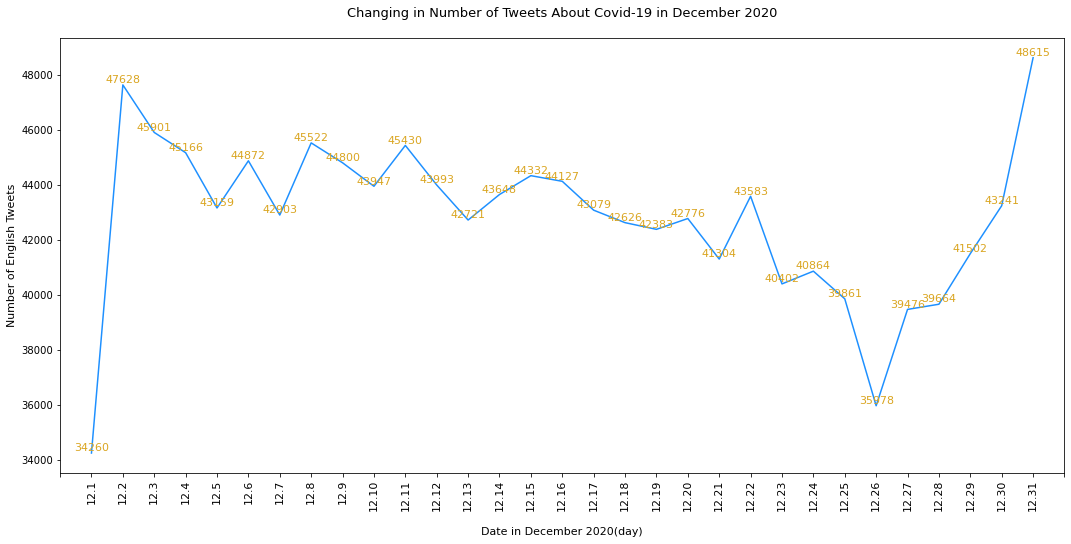

In [6]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
date = dict(sorted(date.items(), key = lambda kv:(kv[0])))
x = list(date.keys())
y = list(date.values())

plt.figure(figsize=(18,8))
plt.title('Changing in Number of Tweets About Covid-19 in December 2020\n',fontsize=13)
plt.xlabel('\nDate in December 2020(day)',fontsize=11)
plt.ylabel('Number of English Tweets',fontsize=11)
plt.xlim(12.00,12.32)
x_label = [f'12.{d}' for d in range(1,32)]
x_label.insert(0,' ')
x_label.insert(0,' ')
plt.xticks(ticks = x, labels = x_label, rotation=90, fontsize=11)
x_major_locator=MultipleLocator(0.01)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.plot(x,y, c = 'dodgerblue')
for a, b in zip(x, y):
    plt.text(a, b+0.05, b, ha='center', va='bottom', fontsize=11,color='goldenrod')
plt.show()

In [7]:
#find how many posts come from each country
country = dict(df['place_country'].value_counts())
print(dict(country))

{'United States': 660497, 'United Kingdom': 160607, 'India': 62948, 'Nigeria': 51224, 'Canada': 47576, 'Republic of the Philippines': 47368, 'South Africa': 25552, 'Australia': 21658, 'Ireland': 16706, 'Malaysia': 15426, 'Indonesia': 15406, 'Brasil': 14262, 'Ghana': 13797, 'France': 7122, 'Uganda': 7046, 'Pakistan': 6792, 'Kenya': 6577, 'Jamaica': 5435, 'United Arab Emirates': 4837, 'Kingdom of Saudi Arabia': 4430, 'Germany': 4270, 'Brazil': 3750, 'Singapore': 3682, 'Deutschland': 3639, 'Spain': 3452, 'Egypt': 3072, 'España': 3015, 'Thailand': 2877, 'México': 2748, 'Japan': 2549, 'The Netherlands': 2531, 'Mexico': 2486, 'Argentina': 2462, 'Zimbabwe': 2420, 'Portugal': 2417, 'Türkiye': 2398, 'Kuwait': 2387, 'Barbados': 2373, 'New Zealand': 2035, 'Italy': 1912, 'Italia': 1846, 'Bahamas': 1784, 'Nederland': 1719, 'Namibia': 1707, 'Turkey': 1699, 'Botswana': 1677, 'Sweden': 1581, 'Colombia': 1452, 'Malawi': 1441, 'Hong Kong': 1276, 'Israel': 1253, 'Republic of Mauritius': 1202, 'Zambia': 1

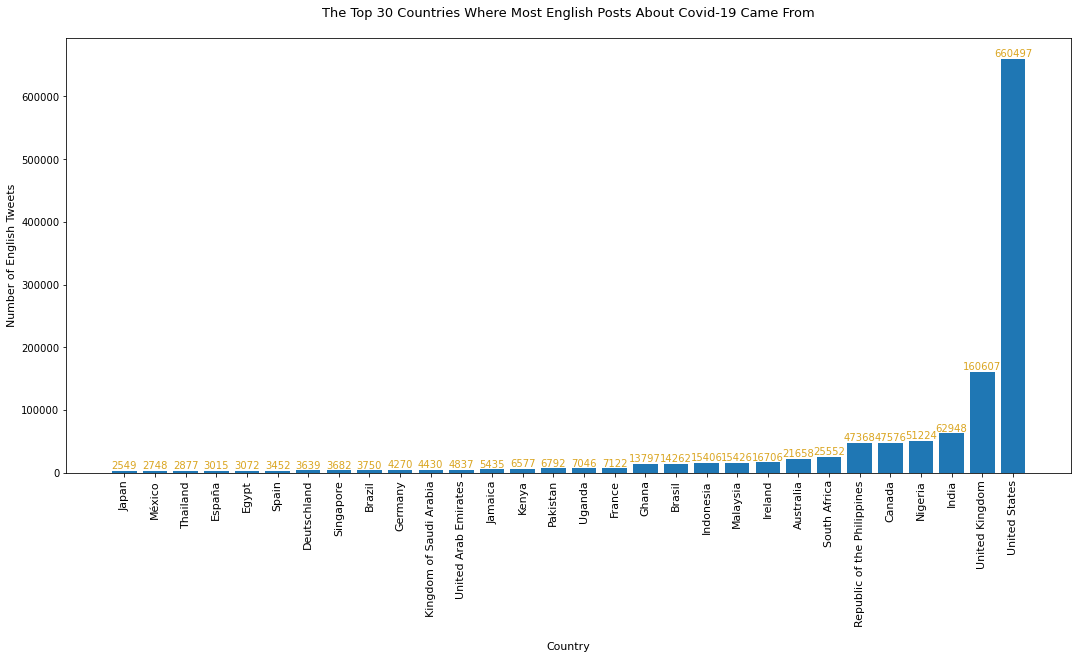

In [8]:
country = dict(sorted(country.items(), key = lambda kv:(kv[1])))
x = list(country.keys())[-30:]
y = list(country.values())[-30:]

plt.figure(figsize=(18,8))
plt.title('The Top 30 Countries Where Most English Posts About Covid-19 Came From\n',fontsize=13)
plt.xlabel('\nCountry',fontsize=11)
plt.ylabel('Number of English Tweets',fontsize=11)
x_position = [p for p in range(30)]
x_label.insert(0,' ')
x_label.insert(0,' ')
plt.xticks(ticks = x_position, labels = x, rotation=90, fontsize=11)
plt.bar(x,y)
for a, b in zip(x, y):
    plt.text(a, b+0.05, b, ha='center', va='bottom', fontsize=10,color='goldenrod')
plt.show()

In [9]:
# preprocess the textual data
def clean(tx):
  clean_data = []
  
  #helper function of function tokenize
  def normalize_token(token):
    token = token.strip()
    if token.startswith("'") or token.endswith("'"):
      token = token.replace("'"," ")
    token = token.strip()
    return token

  #split a sentence into tokens
  def tokenize(text):
    pattern = r"['A-Za-z]+-?[A-Za-z']+"
    reg = re.compile(pattern)
    tokens = reg.findall(text)
    rv = []
    for t in tokens:
      rv.append(normalize_token(t))
    return rv

  def normalize(tokens):
    #change all tokens to lowercase, remove stopwords and words that shorter than 2 characters
    rv = [t.lower() for t in tokens if t not in stopwords.words('english') and len(t) > 2]
    return rv

  clean_data = normalize(tokenize(tx))
  return clean_data

In [10]:
df['text'] = df['text'].astype('str').apply(clean)
df['text'] = df['text'].apply(lambda x: ' '.join(x))
print(df.head(3))

                  location lang  created_at followers_count retweet_count  \
1092369    Wells,Minnesota   en       12.01             238             0   
202176   Stratford, London   en       12.01            1214             0   
647755            Mesa, AZ   en       12.01             898             0   

                                                      text   place_country  
1092369                        southboundduke your welcome   United States  
202176   amazing showing league legends community humbling  United Kingdom  
647755                           will trade shoot weeeeeed   United States  


In [43]:
#combine the labeled real news and fake news datasets
real1 = pd.read_csv('real1.csv')
real2 = pd.read_csv('real2.csv')
fake = pd.read_csv('fake1.csv')
sample_news = pd.concat([real1,real2,fake])
sample_news.dropna()
labels = sample_news['tf']
print(len(sample_news))
print(sample_news.head(3))

1788
                                             content    tf
0      People should NOT wear masks while exercising  Real
1  The likelihood of shoes spreading COVID-19 is ...  Real
2  The coronavirus disease (COVID-19) is caused b...  Real


In [44]:
#build, train, and test the model
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
x_train,x_test,y_train,y_test=train_test_split(sample_news['content'], labels, train_size = 0.75, random_state=6)
x_train,x_test,y_train,y_test = x_train.fillna(''),x_test.fillna(''),y_train.fillna(''),y_test.fillna('')
tfidf_vectorizer=TfidfVectorizer(stop_words=stopwords.words('english'), max_df=0.7,ngram_range=(1,4))
tfidf_train=tfidf_vectorizer.fit_transform(x_train) 
print(x_test.head())
tfidf_test=tfidf_vectorizer.transform(x_test)
pac=PassiveAggressiveClassifier(max_iter=80)
pac.fit(tfidf_train,y_train)

y_pred=pac.predict(tfidf_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')


confusion_matrix(y_test,y_pred, labels=['Fake','Real'])
print(metrics.classification_report(y_test, y_pred))

60      I know there is a risk of getting COVID-19 at ...
959     reassuringly covid-19 in under 25s with diabet...
102     How to wash fruits and vegetables? Just with w...
204                                                      
1389    encuentre respuestas a las preguntas acerca de...
Name: content, dtype: object
Accuracy: 89.49%
              precision    recall  f1-score   support

                   0.90      0.98      0.94       357
        Fake       0.00      0.00      0.00         5
        Real       0.85      0.59      0.69        85

    accuracy                           0.89       447
   macro avg       0.58      0.52      0.54       447
weighted avg       0.88      0.89      0.88       447



C:\Users\jerry\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
tfidf_news=tfidf_vectorizer.transform(df['text'])
prediction = pac.predict(tfidf_news)

In [15]:
# add the predictions to the original table as a new column
df['prediction'] = prediction
print(df.head(3))

                  location lang  created_at followers_count retweet_count  \
1092369    Wells,Minnesota   en       12.01             238             0   
202176   Stratford, London   en       12.01            1214             0   
647755            Mesa, AZ   en       12.01             898             0   

                                                      text   place_country  \
1092369                        southboundduke your welcome   United States   
202176   amazing showing league legends community humbling  United Kingdom   
647755                           will trade shoot weeeeeed   United States   

        prediction  
1092369             
202176              
647755              


In [16]:
df_fake = df[df['prediction'] == 'Fake']
print(df_fake.head(3))

              location lang  created_at followers_count retweet_count  \
119063   san diego ca.   en       12.01            2124             0   
425119   Orange County   en       12.01             177             0   
1215035        Ireland   en       12.01             174             0   

                                      text  place_country prediction  
119063            paint maga they'll catch  United States       Fake  
425119   always fit boys like chunky babes  United States       Fake  
1215035  opara ocha omor wizkid fans catch        Ireland       Fake  


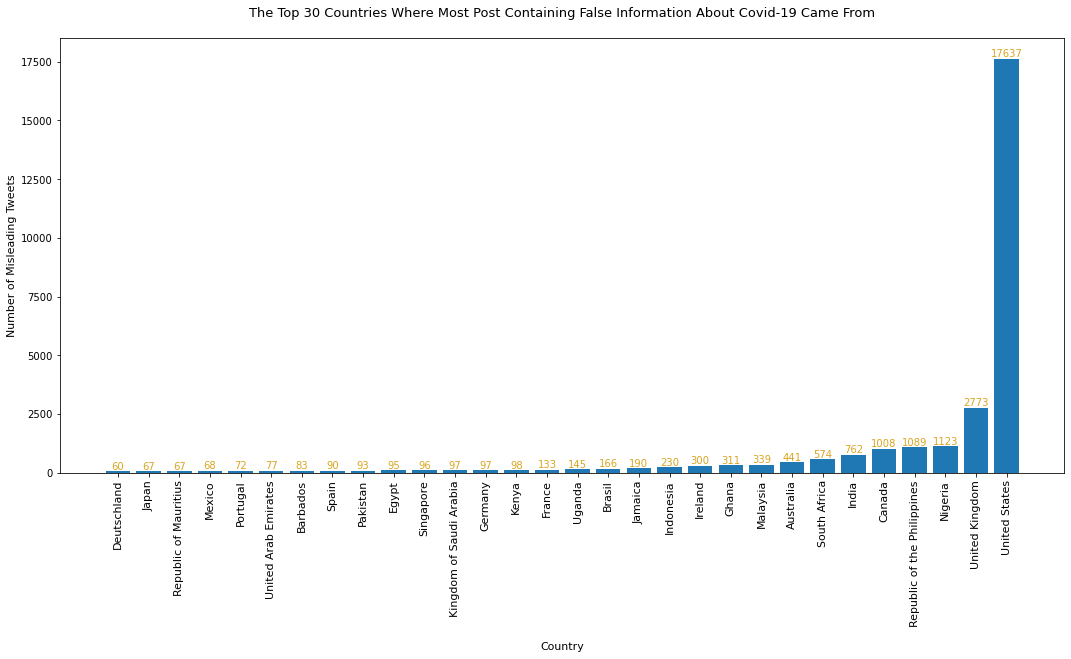

In [147]:
# plot the top 30 countries where most posts containing false information about COVID-19 came from
country_fake = dict(df_fake['place_country'].value_counts())
country_fake = dict(sorted(country_fake.items(), key = lambda kv:(kv[1])))
x = list(country_fake.keys())[-30:]
y = list(country_fake.values())[-30:]

plt.figure(figsize=(18,8))
plt.title('The Top 30 Countries Where Most Post Containing False Information About Covid-19 Came From\n',fontsize=13)
plt.xlabel('\nCountry',fontsize=11)
plt.ylabel('Number of Misleading Tweets',fontsize=11)
x_position = [p for p in range(30)]
x_label.insert(0,' ')
x_label.insert(0,' ')
plt.xticks(ticks = x_position, labels = x, rotation=90, fontsize=11)
plt.bar(x,y)
for a, b in zip(x, y):
    plt.text(a, b+0.05, b, ha='center', va='bottom', fontsize=10,color='goldenrod')
plt.show()

In [22]:
tfidf_news_fake=tfidf_vectorizer.transform(df_fake.text)

In [ ]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
        print(feature_vals)

    #create a tuples of feature,score
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tfidf_news_fake.tocoo())
#extract only the top n; n here is 10
feature_names = tfidf_vectorizer.get_feature_names()
keywords=extract_topn_from_vector(feature_names,sorted_items,500)

In [24]:
#print out the keywords
print("Keywords:")
for k in keywords:
    print(k,keywords[k])

Keywords:
protect 0.87
parcels 1.0
kills 1.0
kill 0.798
dies 0.829
catch 0.889
bleach 0.8
antibiotics 1.0
dogs 0.841
young 0.933
always 0.827
cats 0.841
spring 0.806
die 0.806


In [36]:
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

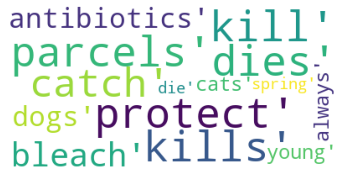

In [42]:
from string import punctuation
stoplist = list(stopwords.words('english')) + list(punctuation)
word_cloud = WordCloud(
                          background_color='white',
                          stopwords=stoplist,
                          max_words=100,
                          max_font_size=50, 
                          random_state=40
                         ).generate(str(keywords))
print(word_cloud)
fig = plt.figure(1)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()